In [26]:
import pandas as pd
import numpy as np
import datetime
import nltk
import string
import re
import os
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('stopwords')

#-- Text Preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#-- Modeling
from sklearn.model_selection import StratifiedKFold
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.svm import NuSVC
from sklearn.ensemble import RandomForestClassifier

### Importing and Preparing Data

In [7]:
start = datetime.datetime.now()

labels = pd.read_fwf("label.txt", header=None)
patents = pd.read_fwf("train.txt", header=None)

finish = datetime.datetime.now()
print("Data has been loaded. Elapsed Time: {} seconds".format((finish-start).total_seconds()))

Data has been loaded. Elapsed Time: 29.154992 seconds


In [8]:
'''
Setting column names for joining
'''
patents = patents.iloc[:,[0,1]]
patents.columns = ['ID', 'Document']
labels.columns = ['ID', 'Label']

In [9]:
pats = patents.join(labels.set_index('ID'), on = 'ID')
pats.head()

,ID,Document,Label
0,20030006121,Passive radio frequency identification system ...,8
1,20030009666,Methods and apparatus for efficient computatio...,0
2,20030014337,"Systems, methods and computer program products...",8
3,20030019942,System and method for electronically readable ...,8
4,20030033242,System and method for automated process of dea...,6


### Preprocessing

In [10]:
#Removing Punctuation

def no_punctuation(document):
    no_punc = ''.join([character for character in document if character not in string.punctuation])
    return no_punc

start = datetime.datetime.now()
pats.Document = list(map(no_punctuation, pats.Document))
finish = datetime.datetime.now()

print("Punctuation removed from patent! Elapsed Time: {} seconds".format((finish-start).total_seconds()))

Punctuation removed from patent! Elapsed Time: 14.348659 seconds


In [11]:
# Tokenization
def tokenize(document):
    tokened = nltk.word_tokenize(document)
    return tokened

start = datetime.datetime.now()
pats.Document = list(map(tokenize, pats.Document))
finish = datetime.datetime.now()

print("Patents tokenized! Elapsed Time: {} seconds".format((finish-start).total_seconds()))


Patents tokenized! Elapsed Time: 92.307841 seconds


In [12]:
# Stop Word and Numeric Removal 
def no_stops(document):
    stop_words = set(stopwords.words('english'))
    no_stop = [word.lower() for word in document if word not in stop_words]
    no_numeric = [word for word in no_stop if not any(num.isdigit() for num in word)]
    return no_numeric

start = datetime.datetime.now()
pats.Document = list(map(no_stops, pats.Document))
finish = datetime.datetime.now()

print("Stop words removed from patents! Elapsed Time: {} seconds".format((finish-start).total_seconds()))

Stop words removed from patents! Elapsed Time: 17.724577 seconds


In [13]:
# Stemming [state = 0], Lemmatizing [state = 1]

def generate_root(document, state):
    if state == 0:
        stemmer = PorterStemmer()
        stemmed = [stemmer.stem(word.lower()) for word in document] 
        return stemmed
    elif state == 1:
        '''
        Lemmatization has a drawback of needing to specify part of speech. Example:
            For noun, 'building' == 'building',
            For verb, 'building' == 'build'
        '''
        lemmatizer = WordNetLemmatizer()
        lemmatized = [lemmatizer.lemmatize(word.lower(), pos = ['n']) for word in document]
        return lemmatized
    else:
        return document

    
start = datetime.datetime.now()
pats.Document = list(map(lambda x: generate_root(x,0), pats.Document)) #State is specified here
finish = datetime.datetime.now()

print("Root words generated for patents! Elapsed Time: {} seconds".format((finish-start).total_seconds()))

Root words generated for patents! Elapsed Time: 271.92084 seconds


In [14]:
# Rejoining Text After Cleaning

def cleaned_document(document):
    doc = ' '.join(document)
    return doc

start = datetime.datetime.now()
pats.Document = pats.Document.apply(cleaned_document)
finish = datetime.datetime.now()

print("Patents have been rejoined after preprocessing! Elapsed Time: {} seconds".format((finish-start).total_seconds()))

Patents have been rejoined after preprocessing! Elapsed Time: 0.80396 seconds


### Vectorization of Documents

In [15]:
pats.Document[0:7]

0    passiv radio frequenc identif system identifi ...
1    method apparatu effici comput oneway chain cry...
2    system method comput program product perform g...
3    system method electron readabl card power sour...
4    system method autom process deal structur an a...
5    vehicl shop buy system method a complet intern...
6    game cash manag slip method the invent cash ma...
Name: Document, dtype: object

In [16]:
tfidf = TfidfVectorizer(ngram_range = (1,2), analyzer ='word',min_df = .1, max_df=.95)

vectors = tfidf.fit_transform(pats.Document)
vectorDF = pd.DataFrame(data=vectors.toarray())
vectorDF.columns = tfidf.get_feature_names()

vectorDF.head()

,abil,abl,abl access,abl use,abovedescrib,absenc,abstract,acceler,accept,accept payment,...,xml,ye,year,yet,yet anoth,yield,zero,zip,zip code,âˆ
0,0.015772,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.000000,0.001681,0.0,0.0,0.019868,0.000000,0.000000,0.0,0.003259,0.0,...,0.0,0.000000,0.004388,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.002063,0.001789,0.0,0.0,0.003524,0.000000,0.000000,0.0,0.001734,0.0,...,0.0,0.000000,0.004670,0.000000,0.0,0.0,0.043756,0.0,0.0,0.0
3,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.019893,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.003374,0.001462,0.0,0.0,0.000000,0.001566,0.002956,0.0,0.007798,0.0,...,0.0,0.000000,0.022909,0.000796,0.0,0.0,0.000000,0.0,0.0,0.0


### Modeling

In [17]:
df = vectorDF.join(labels.Label)
df_features = df.drop('Label', axis = 1)
df_target = df['Label']

In [41]:
# Prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('LiSVM', LinearSVC()))
models.append(('NuSVM', NuSVC(nu= 0.19)))
models.append(('RF', RandomForestClassifier()))

In [42]:
# Evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.StratifiedKFold(n_splits=10, random_state=1)
    cv_results = model_selection.cross_val_score(model, df_features, df_target, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name) 
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.637903 (0.083072)
LDA: 0.139238 (0.060730)
KNN: 0.578185 (0.056545)
DT: 0.483543 (0.068328)
NB: 0.560757 (0.071605)
LiSVM: 0.668566 (0.076503)
NuSVM: 0.545615 (0.093381)
RF: 0.543585 (0.058385)


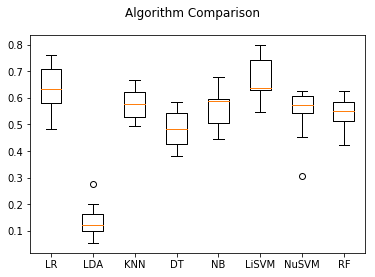

In [44]:
# Boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
fig.savefig('ModelPerformance.png')

---
### TESTS

In [103]:
yun = "Hey what!? Why? Helping, a countries, country"
stemmer.stem(yun)

'hey what!? why? helping, a countries, countri'

In [143]:
tf = TfidfVectorizer(analyzer ='word',min_df = .01, max_df=.95)


test = ["Hey what!? Why? Helping, a countries, country", "Hmmm????!"]
test = list(map(no_punctuation, test))
test = list(map(tokenize, test))
test = list(map(no_stops, test))
test = list(map(lambda x: generate_root(x,0),test))
test = map(cleaned_document, test)
#test = Counter(test[0]).most_common()

test
vec = tf.fit_transform(test)
pd.DataFrame(vec.toarray())
#test = ''.join([character for character in test if character not in string.punctuation])
tf.get_feature_names()

['countri', 'help', 'hey', 'hmmm', 'whi']

In [111]:
test[0]

['hey', 'whi', 'help', 'countri', 'countri']

In [110]:
doc = ' '.join(test[0])
doc

'hey whi help countri countri'

In [172]:
pats.head()

,ID,Document,Label
0,20030006121,passiv radio frequenc identif system identifi ...,8
1,20030009666,method apparatu effici comput oneway chain cry...,0
2,20030014337,system method comput program product perform g...,8
3,20030019942,system method electron readabl card power sour...,8
4,20030033242,system method autom process deal structur an a...,6


In [100]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    
	# lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    doc = stemmer.stem(doc)
    print(doc[0:9])
	# tokenize document
    tokens = wpt.tokenize(doc)
    
	# filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    print(filtered_tokens[0])
	# re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

patents.Document[:2].apply(normalize_document)

passive r
passive
methods a
methods


0    passive radio frequency identification system ...
1    methods apparatus efficient computation oneway...
Name: Document, dtype: object

In [104]:
stemmer.stem('passive')

'passiv'

In [217]:
def returned():
    nums = [2,3,5,6,8,89,3,2]
    for num in nums:
        s = num**2
        yield s
    
def iterate(y):
    print(y)

    
iterate(9)
        

9
